# 3 Klassifikation des Objekttyps (1/4)
Ziel dieser Aufgabe ist es, ein Modell zu erstellen, welches durch beliebige Metriken eine akkurate Vorhersage über den Typ der Immobilie erstellt.

Hier versuchen wir durch ein neuronales Netzwerk mit ReLu und Softmax Aktivierungsfunktionen ein gutes Modell zu erstellen. 

## Importieren der benötigten Libraries und Daten

- Zur Erstellung des Modells nutzen wir PyTorch (torch). 
- Für die Umwandlung unserer Variablen in 32 bit Floats und Berechnung einiger Werte nutzen wir Numpy. 
- Für das Einlesen der Daten und die Verarbeitung dieser, nutzen wir Pandas. 
- Für die Visualisierung der Losses nutzen wir Matplotlib.
- Für die Skalierung unserer Features und die Trennung von Training- und Validierungsdaten nutzen wir sklearn.

In [1]:
# Import needed libraries
import torch  # install via command provided in https://pytorch.org/get-started/locally/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Die Daten beziehen wir aus unserem Data Repository auf GitHub.

In [2]:
# read clean data + plz data
data = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv"
)
data = data[["price", "zip_code", "living_space", "rooms", "type"]]
plz = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv"
)

## Datenverarbeitung

Um unsere kategorialen Zielvariable Type vorherzusagen, müssen wir sie in Dummies umwandeln, da wir nur numerische Werte berechnen können.

In [3]:
# print all object types (this will be the categories in our y)
data["type"].unique()

array(['penthouse', 'terrace-house', 'detached-house', 'flat',
       'stepped-house', 'farmhouse', 'semi-detached-house',
       'stepped-apartment', 'duplex-maisonette', 'attic-flat', 'loft',
       'chalet', 'villa', 'attic-room', 'secondary-suite', 'castle',
       'detached-secondary-suite', 'studio',
       'furnished-residential-property', 'rustico', 'single-room'],
      dtype=object)

Zunächst kombinieren wir unseren reduzierten Wohnungsdatensatz mit unserem Postleitzahl Datensatz, um weitere Features zu erhalten.

In [4]:
# join clean data with plz data on plz
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how="inner", left_on="zip_code", right_on="PLZ")
data = data.drop(columns=["PLZ", "zip_code"])

# print number of observations + data preview
print(len(data))
data

13050


,price,living_space,rooms,type_attic-flat,type_attic-room,type_castle,type_chalet,type_detached-house,type_detached-secondary-suite,type_duplex-maisonette,...,PLZ_Group_9000,PLZ_Group_9100,PLZ_Group_9200,PLZ_Group_9300,PLZ_Group_9400,PLZ_Group_9500,PLZ_Group_9600,PLZ_Group_9700,PLZ_Group_9800,PLZ_Group_9900
0,1150000.0,100.0,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1420000.0,156.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1430000.0,154.0,4.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,550000.0,124.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,720000.0,93.0,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13045,895000.0,130.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13046,1090000.0,147.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13047,2750000.0,385.0,7.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13048,1415000.0,150.0,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hier analysieren wir, wieviel NA Werte unser Datensatz hat.

In [5]:
# check how many NA in every column
data.isna().sum().sort_values(ascending=False)

living_space                         1053
price                                1011
rooms                                 564
PLZ_Group_9800                          0
PLZ_Group_4100                          0
                                     ... 
NoisePollutionRailwayL                  0
gde_politics_fdp                        0
gde_social_help_quota                   0
gde_area_nonproductive_percentage       0
PLZ_Group_9900                          0
Length: 162, dtype: int64

Da unser Datensatz nur wenig NAs hat, verwerfen wir diese Observationen. Uns bleiben noch um die 11000 Datensätze.

In [6]:
# drop NAs
data = data.dropna()
# print new number of observations
len(data)

10922

Unsere Daten spalten wir danach in Features und Zielvariablen.

In [7]:
# define columns for X and y
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

# convert pandas data to numpy arrays
X = data[X_cols].values
y = data[y_cols].values

Danach skalieren wir unsere Features mit einem StandardScaler auf die Werte aus unserem ganzen Datensatz.

In [8]:
# scale data to whole dataset
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Unsere Daten unterteilen wir danach auf Trainings- und Validierungsdaten.

In [9]:
# split train and val data (70%/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=420)

Hier wandeln wir unsere Numpy Werte in Float32 Werte, damit die Berechnung durch PyTorch effizienter verlauft.

In [10]:
# create tensors from numpy arrays
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))

# Modell

Danach erstellen wir die Architektur unseres Modells indem wir unsere Layers und den Verlauf der Forwardpropagation definieren.

In [11]:
# define model architecture
class Gabonisator(torch.nn.Module):
    # run super and define layers
    def __init__(self, n_features, n_outputs):
        super(Gabonisator, self).__init__()
        # define first hidden layer | input -> 64 nodes
        self.hidden1 = torch.nn.Linear(n_features, 64)
        # define second hidden layer | 64 nodes -> 64 nodes
        self.hidden2 = torch.nn.Linear(64, 64)
        # define output layer | 64 nodes -> output
        self.output = torch.nn.Linear(64, n_outputs)

    # define forward prop
    def forward(self, X):
        # first hidden layer + relu activation function
        y_pred = self.hidden1(X)
        y_pred = torch.relu(y_pred)
        # second hidden layer + relu activation function
        y_pred = self.hidden2(y_pred)
        y_pred = torch.relu(y_pred)
        # output layer + softmax to normalize results
        y_pred = self.output(y_pred)
        y_pred = torch.softmax(y_pred, dim=1)
        # return calculated y values
        return y_pred

Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>

Dieses Modell erstellen wir danach und definieren eine Learning Rate, eine Lossfunction und ein Optimizer.
Als Lossfunction nehmen wir die Binary-Crossentropy und als Optimizer Adam.
Danach trainieren wir unser Modell und speichern unsere Losses nach jeder Epoche.

In [12]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train)
    # loss function
    loss_train = lossf(y_pred, y_train)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
    )
    print(
        f"   Best val loss: {np.min(loss_val_arr):.4f} at Epoch {np.argmin(loss_val_arr) + 1}"
    )

Epoch:   500/10000 | Loss train: 0.1432 | Loss val: 0.1447
Epoch:  1000/10000 | Loss train: 0.1128 | Loss val: 0.1175
Epoch:  1500/10000 | Loss train: 0.1046 | Loss val: 0.1108
Epoch:  2000/10000 | Loss train: 0.0984 | Loss val: 0.1057
Epoch:  2500/10000 | Loss train: 0.0936 | Loss val: 0.1020
Epoch:  3000/10000 | Loss train: 0.0900 | Loss val: 0.0998
Epoch:  3500/10000 | Loss train: 0.0873 | Loss val: 0.0984
Epoch:  4000/10000 | Loss train: 0.0850 | Loss val: 0.0978
Epoch:  4500/10000 | Loss train: 0.0829 | Loss val: 0.0975
Epoch:  5000/10000 | Loss train: 0.0809 | Loss val: 0.0977
Epoch:  5500/10000 | Loss train: 0.0790 | Loss val: 0.0981
Epoch:  6000/10000 | Loss train: 0.0771 | Loss val: 0.0987
Epoch:  6500/10000 | Loss train: 0.0751 | Loss val: 0.0996
Epoch:  7000/10000 | Loss train: 0.0731 | Loss val: 0.1007
Epoch:  7500/10000 | Loss train: 0.0712 | Loss val: 0.1020
Epoch:  8000/10000 | Loss train: 0.0692 | Loss val: 0.1036
Epoch:  8500/10000 | Loss train: 0.0672 | Loss val: 0.10

Um einen Überblick zu erhalten, wie gut das Modell jetzt trainiert wurde, visualisieren wir unsere Losses nach jeder Epoche.

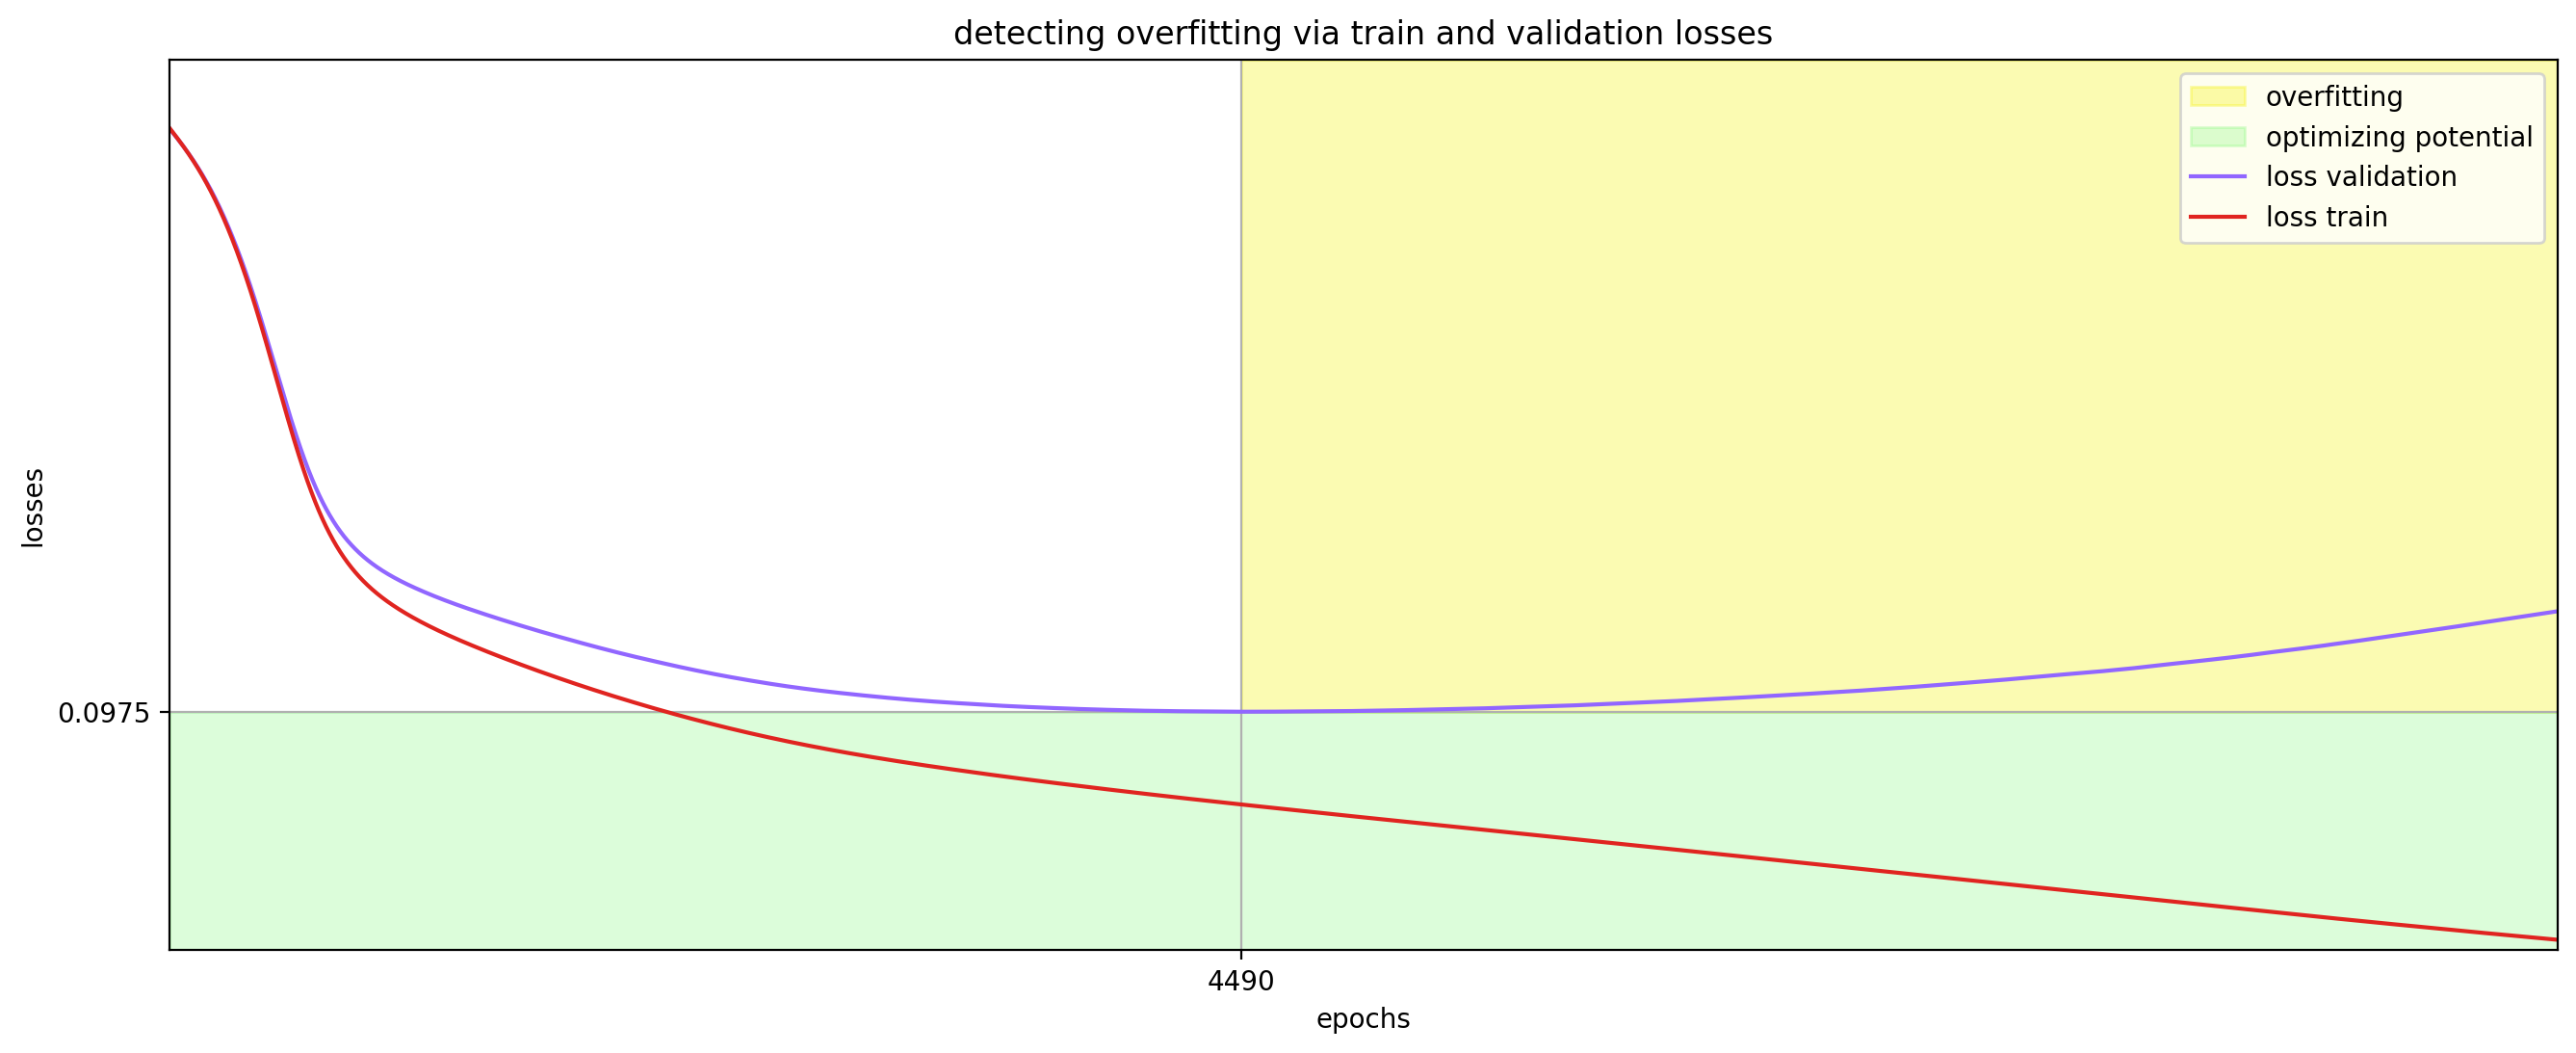

In [13]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

Wie wir hier erkennen können, passiert nach einer bestimmten Zahl Iterationen overfitting, da der Loss Wert unseres Validierungsdatensatzes steigt, anstatt zu sinken. Um dies zu bekämpfen, muss das Modell selbst erkennen, dass Overfitting stattfindet und frühzeitig abbrechen. Dafür implemntieren wir ein Early Stopping, welches überprüft, ob der letzte Loss Wert kleiner ist, als der aktuelle. Falls dies der Fall ist, hört das Modell auf zu trainieren.

In [14]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train)
    # loss function
    loss_train = lossf(y_pred, y_train)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # loss val goes up too much -> EarlyStop
    if np.round(np.min(loss_val_arr), 4) != np.round(loss_val.item(), 4):
        print("Early Stopping!")
        break

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    score = (
        (model(X_val).argmax(axis=1) == y_val.argmax(axis=1)).sum() / y_val.shape[0]
    ).item()
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f} | Score: {score:.4f}"
    )


Epoch:   500/10000 | Loss train: 0.1504 | Loss val: 0.1518
Epoch:  1000/10000 | Loss train: 0.1146 | Loss val: 0.1185
Epoch:  1500/10000 | Loss train: 0.1061 | Loss val: 0.1118
Epoch:  2000/10000 | Loss train: 0.0999 | Loss val: 0.1071
Epoch:  2500/10000 | Loss train: 0.0949 | Loss val: 0.1033
Epoch:  3000/10000 | Loss train: 0.0910 | Loss val: 0.1007
Epoch:  3500/10000 | Loss train: 0.0880 | Loss val: 0.0991
Epoch:  4000/10000 | Loss train: 0.0854 | Loss val: 0.0983
Epoch:  4500/10000 | Loss train: 0.0832 | Loss val: 0.0980
Early Stopping!
---
Final Run
Epoch:  4713/10000 | Loss train: 0.0822 | Loss val: 0.0981 | Score: 0.6121


Jetzt visualisieren wir unsere Ergebnisse anhand der gleichen Visualisierung wie vorhin.

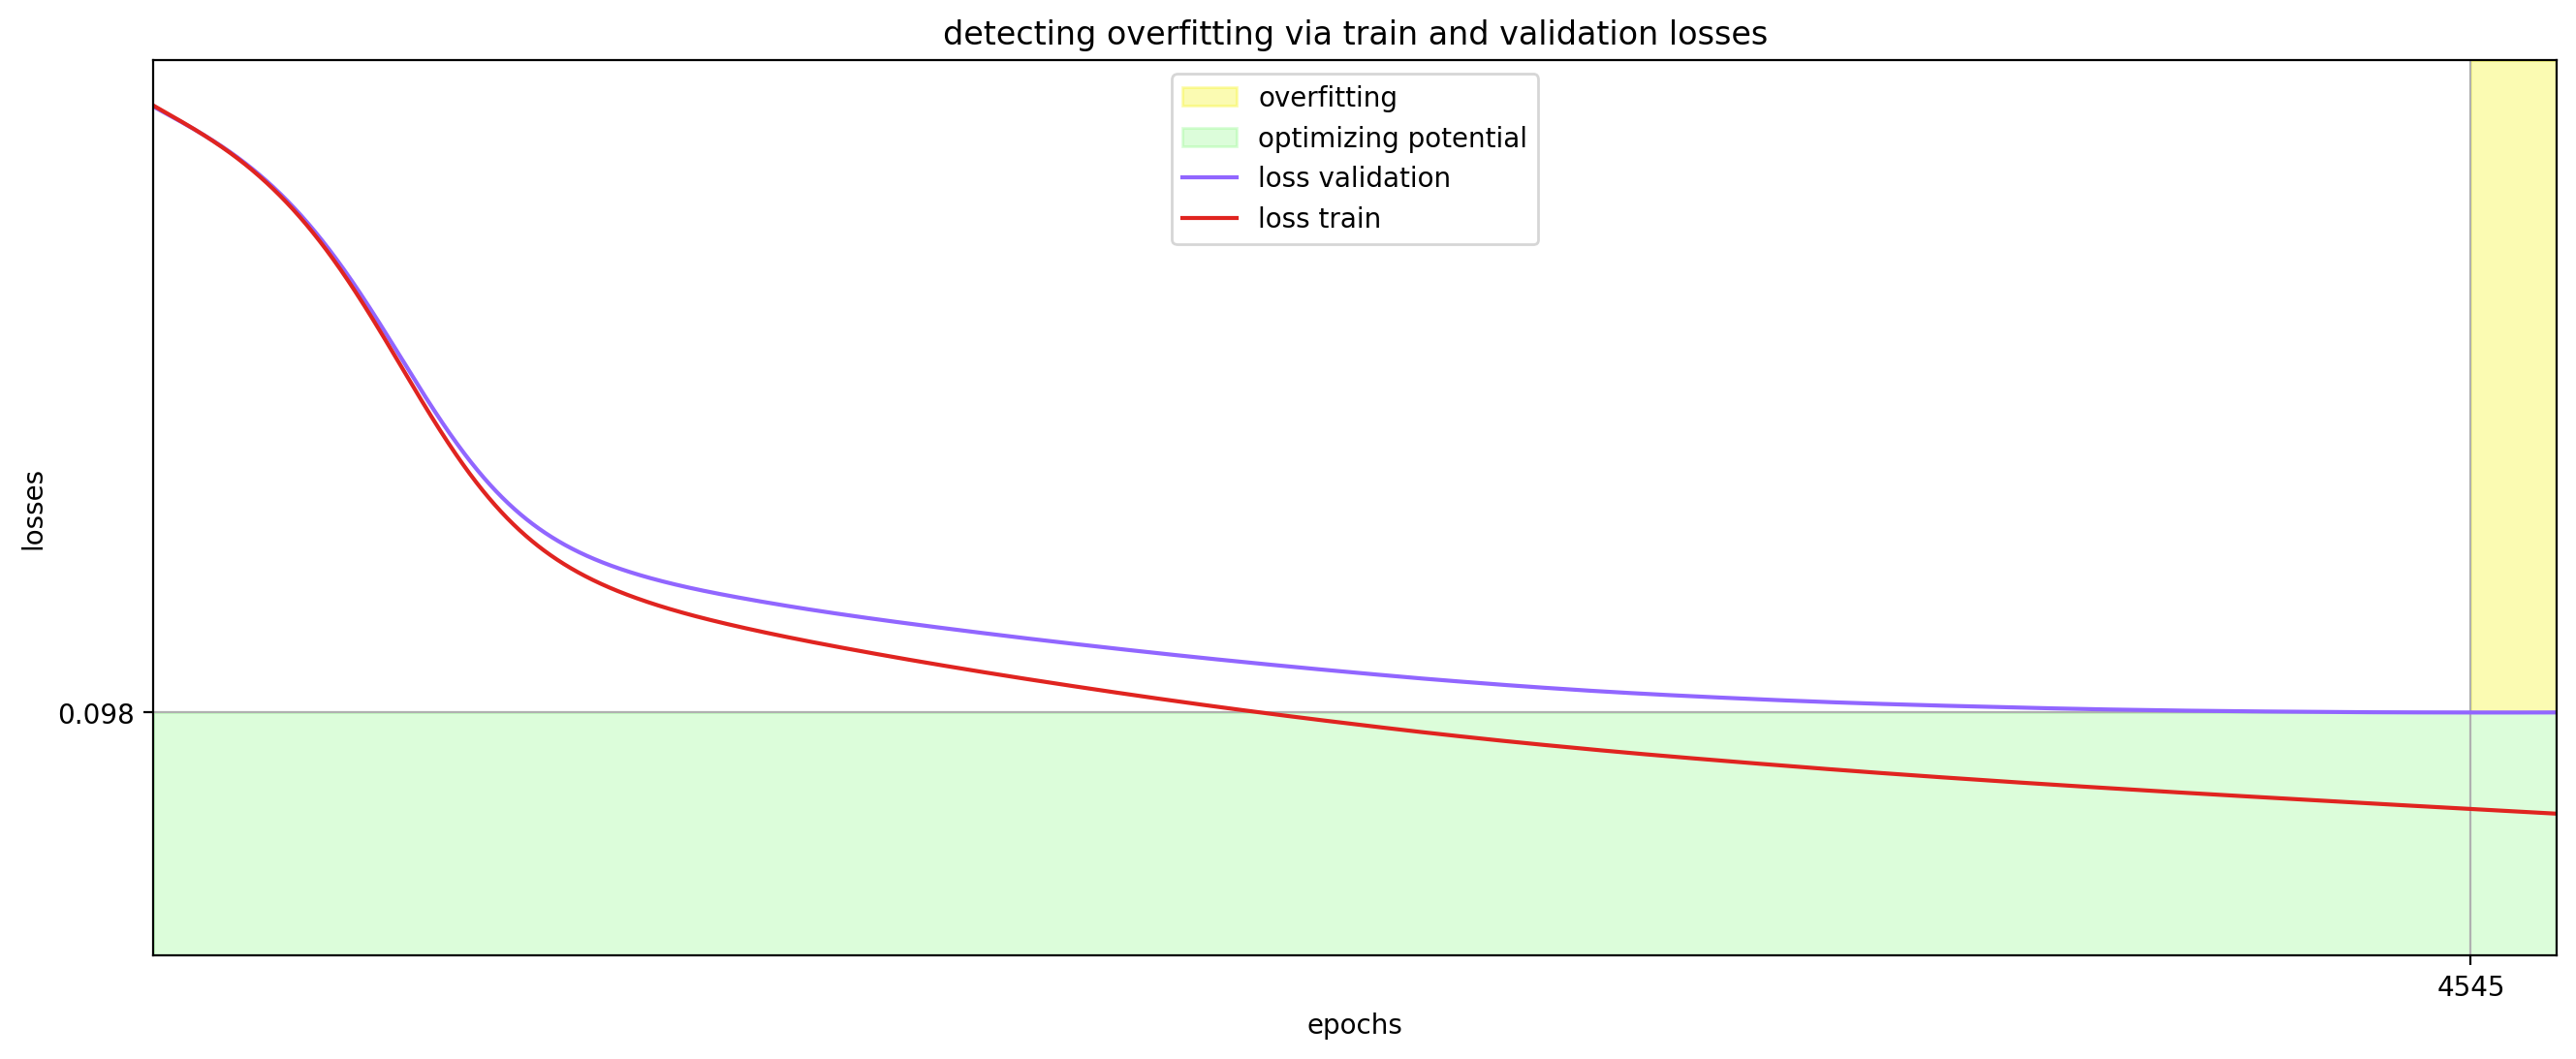

In [15]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

Unser Modell bricht jetzt frühzeitig ab und verhindert somit overfitting. Unsere Accuracy ist mit diesem Modell über 60%.